In [1]:
%load_ext autoreload
%autoreload 2

# Ovrlpy analysis tutorial of Xenium mouse brain data

In this notebook, we will use ovrlpy to investigate the Xenium's mouse brain dataset. We want to create a signal embedding of the transcriptome, and a vertical signal incoherence map to identify locations with a high risk of containing spatial doublets.


#### Loading the data:

in a first step, we want to load the data and 

In [2]:
from pathlib import Path

data_folder_path = Path("/dh-projects/ag-ishaque/raw_data/tiesmeys-ovrlpy/Xenium-brain-2024/replicate1")

kde_bandwidth = 2.5
min_expression = 2.0


x            y          z     gene  cell_id  overlaps_nucleus  \
0  4843.045898  6427.729980  19.068869  Bhlhe40    67490                 1   
1  4844.632812  6223.182617  18.520161    Parm1    67957                 0   
2  4842.943359  6478.310547  18.500109  Bhlhe40    67539                 1   
3  4843.941406  6344.550293  15.016154     Lyz2    68003                 0   
4  4843.162598  6632.111816  15.394680     Dkk3    67344                 0   

          qv  
0  40.000000  
1  40.000000  
2  13.813585  
3  19.471884  
4  40.000000

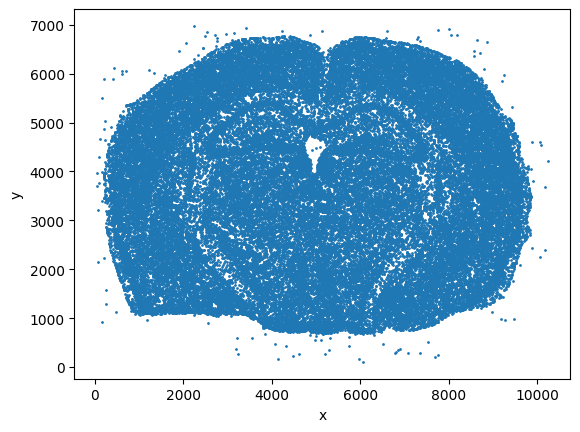

In [3]:
import pandas as  pd
# import scanpy as sc
# import squidpy as sq

coordinate_df = pd.read_parquet(data_folder_path/"transcripts.parquet")
coordinate_df["feature_name"]=coordinate_df.feature_name.str.decode("utf-8")


# remove dummy molecules:
dummy_mask = (coordinate_df.feature_name.str.contains('BLANK') | coordinate_df.feature_name.str.contains('NegControl'))
coordinate_df = coordinate_df[~dummy_mask]

# format columns:
coordinate_df = coordinate_df[['x_location','y_location','z_location','feature_name','cell_id','overlaps_nucleus','qv']]
coordinate_df.columns = ['x','y','z','gene','cell_id','overlaps_nucleus','qv']
coordinate_df['gene'] = coordinate_df['gene'].astype("category")

coordinate_df[::1000].plot.scatter(x='x',y='y',s=1)

coordinate_df.head()

In [9]:
from ovrlpy import ovrlp 
import random

random.seed(42)

integrity, signal, visualizer = ovrlp.compute_coherence_map(df=coordinate_df,)


/dh-projects/ag-ishaque/analysis/tiesmeys/src/ovrlpy-dev/ovrlpy/ovrlp.py:119: RuntimeWarning: Mean of empty slice
  elevation_map_ += (
/dh-projects/ag-ishaque/analysis/tiesmeys/src/ovrlpy-dev/ovrlpy/ovrlp.py:122: RuntimeWarning: Mean of empty slice
  elevation_map_ += (
/dh-projects/ag-ishaque/analysis/tiesmeys/src/ovrlpy-dev/ovrlpy/ovrlp.py:125: RuntimeWarning: Mean of empty slice
  elevation_map_ += (
/dh-projects/ag-ishaque/analysis/tiesmeys/src/ovrlpy-dev/ovrlpy/ovrlp.py:128: RuntimeWarning: Mean of empty slice
  


['Collection', 'Iterable', 'Optional', 'ThreadPoolExecutor', '__builtins__', '__cached__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '_sample_expression_nd', 'anndata', 'as_completed', 'count_cells_at_localmax', 'fftconvolve', 'np', 'pd', 'sample_expression', 'tqdm', 'utils']
Analyzing in 3d mode:
determining local maxima:
Searching within x:(1, 4111), y:(1, 2815), n_molecules:62384369
Using bandwidth: 2.5, min_expression: 2, min_pixel_distance: 10
found 42492 local maxima


/dh-projects/ag-ishaque/analysis/tiesmeys/src/ovrlpy-dev/conda-env/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


sampling expression:


Wfs1: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 248/248 [00:54<00:00,  4.57it/s]
/dh-projects/ag-ishaque/analysis/tiesmeys/src/ovrlpy-dev/conda-env/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/dh-projects/ag-ishaque/analysis/tiesmeys/src/ovrlpy-dev/conda-env/lib/python3.12/site-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/dh-projects/ag-ishaque/analysis/tiesmeys/src/ovrlpy-dev/conda-env/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/dh-projects/ag-ishaque/analysis/tiesmeys/src/ovrlpy-dev/conda-env/lib/python3.12/site-packages/numpy/_core/_methods.py:130: RuntimeWarni

[    0  1027  2055  3082  4110  5138  6165  7193  8220  9248 10276] [   0 1005 2010 3015 4021 5026 6031 7037]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [11:45<00:00, 10.08s/it]


In [20]:
visualizer.pca_2d.components_.shape

(34, 248)

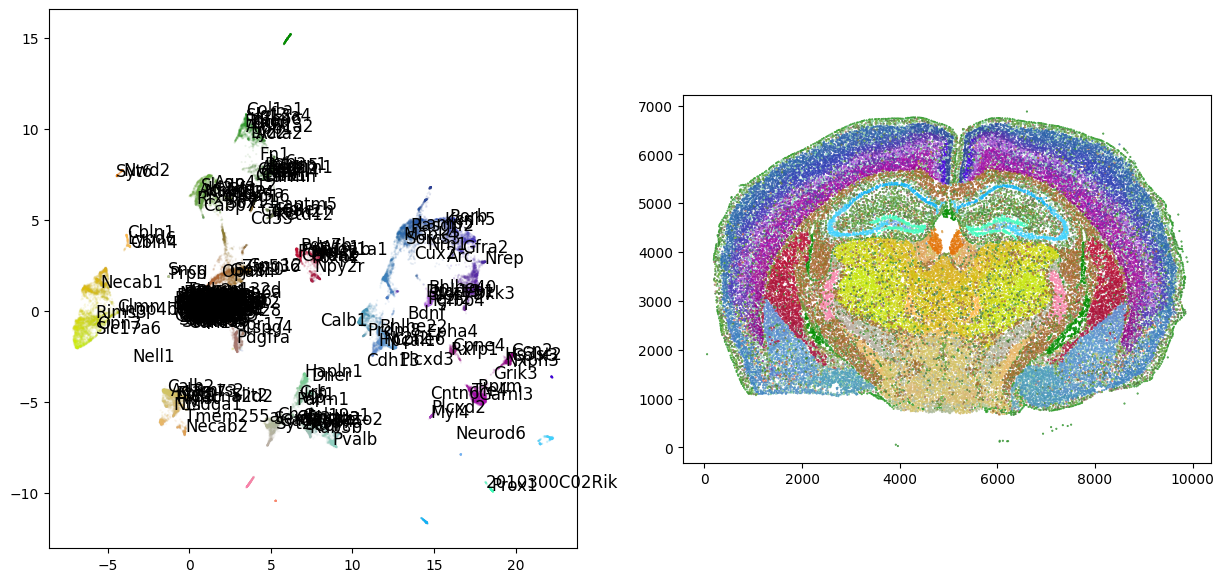

In [18]:
visualizer.plot_fit()

11


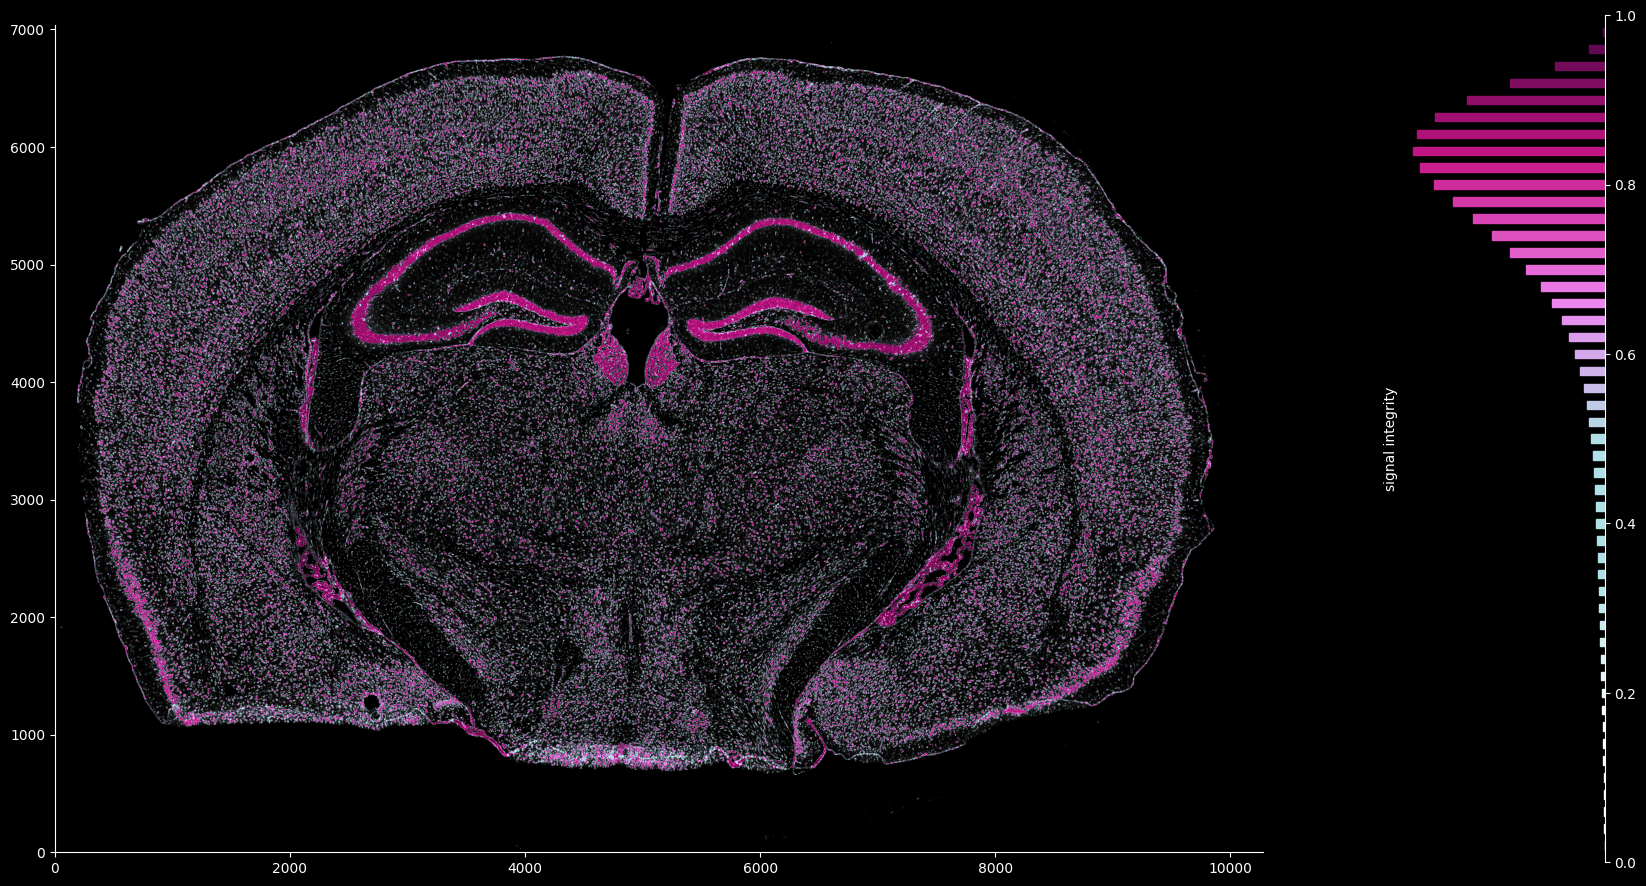

In [33]:
fig, ax = ovrlp.plot_signal_integrity(integrity,signal,signal_threshold=3.0)


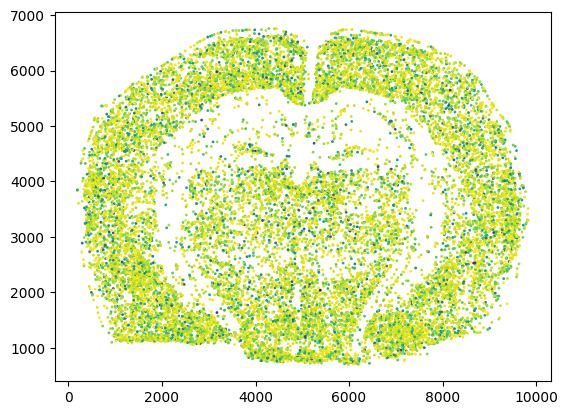

In [21]:
import matplotlib.pyplot as plt
doublet_df = ovrlp.detect_doublets(integrity,signal,signal_cutoff=4,coherence_sigma=3)

plt.scatter(doublet_df.x,doublet_df.y,c=doublet_df.integrity,s=1,cmap='viridis_r')


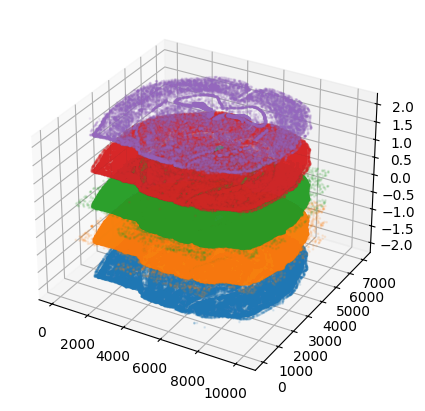

In [22]:
import matplotlib.pyplot as plt
import numpy as np 

plt.figure(figsize=(20,5,))

ax = plt.subplot(111,projection='3d')

for i in range(-2,3):
    subset = coordinate_df[(coordinate_df.z-coordinate_df.z_delim).between(i,i+1)]
    
    ax.scatter(subset.x[::100],subset.y[::100],np.zeros(1+(len(subset)//100))+i,s=1,alpha=0.1)
    

In [24]:
import anndata as sc
adata = sc.read_mtx(data_folder_path/"cell_feature_matrix/matrix.mtx").T
adata.var = pd.read_csv(data_folder_path/"cell_feature_matrix/features.tsv", header=None, index_col=1, names=["gene_id", "gene", "feature_type"],sep="\t")
obs_dict = pd.read_parquet(data_folder_path/"cells.parquet",)#.set_index("cell_id")
for c in obs_dict.columns:
    adata.obs[c] = obs_dict[c].values
adata.obs.set_index("cell_id",inplace=True)
adata.obs.index = adata.obs.index.astype("category")
adata.obs[['x_centroid','y_centroid']]

# Filter out empty cells:
# adata = adata[adata.X.sum(axis=1)>50]

x_centroid   y_centroid
cell_id                          
1        1557.532239  2528.022437
2        1560.669312  2543.632678
3        1570.462885  2530.810461
4        1573.927734  2546.454529
5        1581.344379  2557.024951
...              ...          ...
162029   8310.558740  4345.094580
162030   8316.195801  4321.954077
162031   8323.133594  4271.474121
162032   8327.415137  4348.097388
162033   8326.575928  4248.579736

[162033 rows x 2 columns]

/tmp/ipykernel_364854/958991365.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  signatures = signatures.fillna(0)


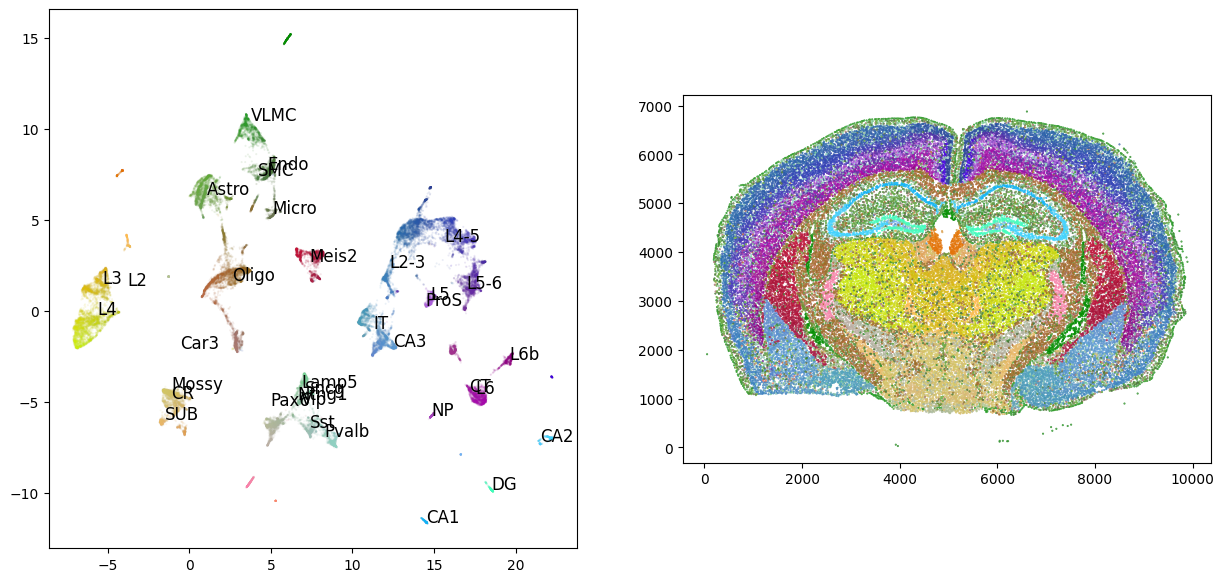

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import warnings

signatures_ = pd.read_csv('/dh-projects/ag-ishaque/raw_data/Xenium-benchmark/scRNAseq/trimmed_means.csv',index_col=0)

signatures_ = signatures_.T.groupby(lambda x: x.split('_')[1].split(' ')[0].split('-')[0]).apply(lambda x: x.mean(0)).T

signatures = pd.DataFrame(index=visualizer.genes,columns=signatures_.columns)
signatures = signatures.fillna(0)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for gene in visualizer.genes:
        if gene in signatures_.index:
            signatures.loc[gene] = signatures_.loc[gene]

del signatures_ 

signatures.columns=signatures.columns.str.replace('/','-')

visualizer.fit_signatures(signatures)

visualizer.plot_fit()

# plt.savefig("./manuscript/figures/results/xenium-brain/ct_fit.svg")

/dh-projects/ag-ishaque/analysis/tiesmeys/src/ovrlpy-dev/conda-env/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


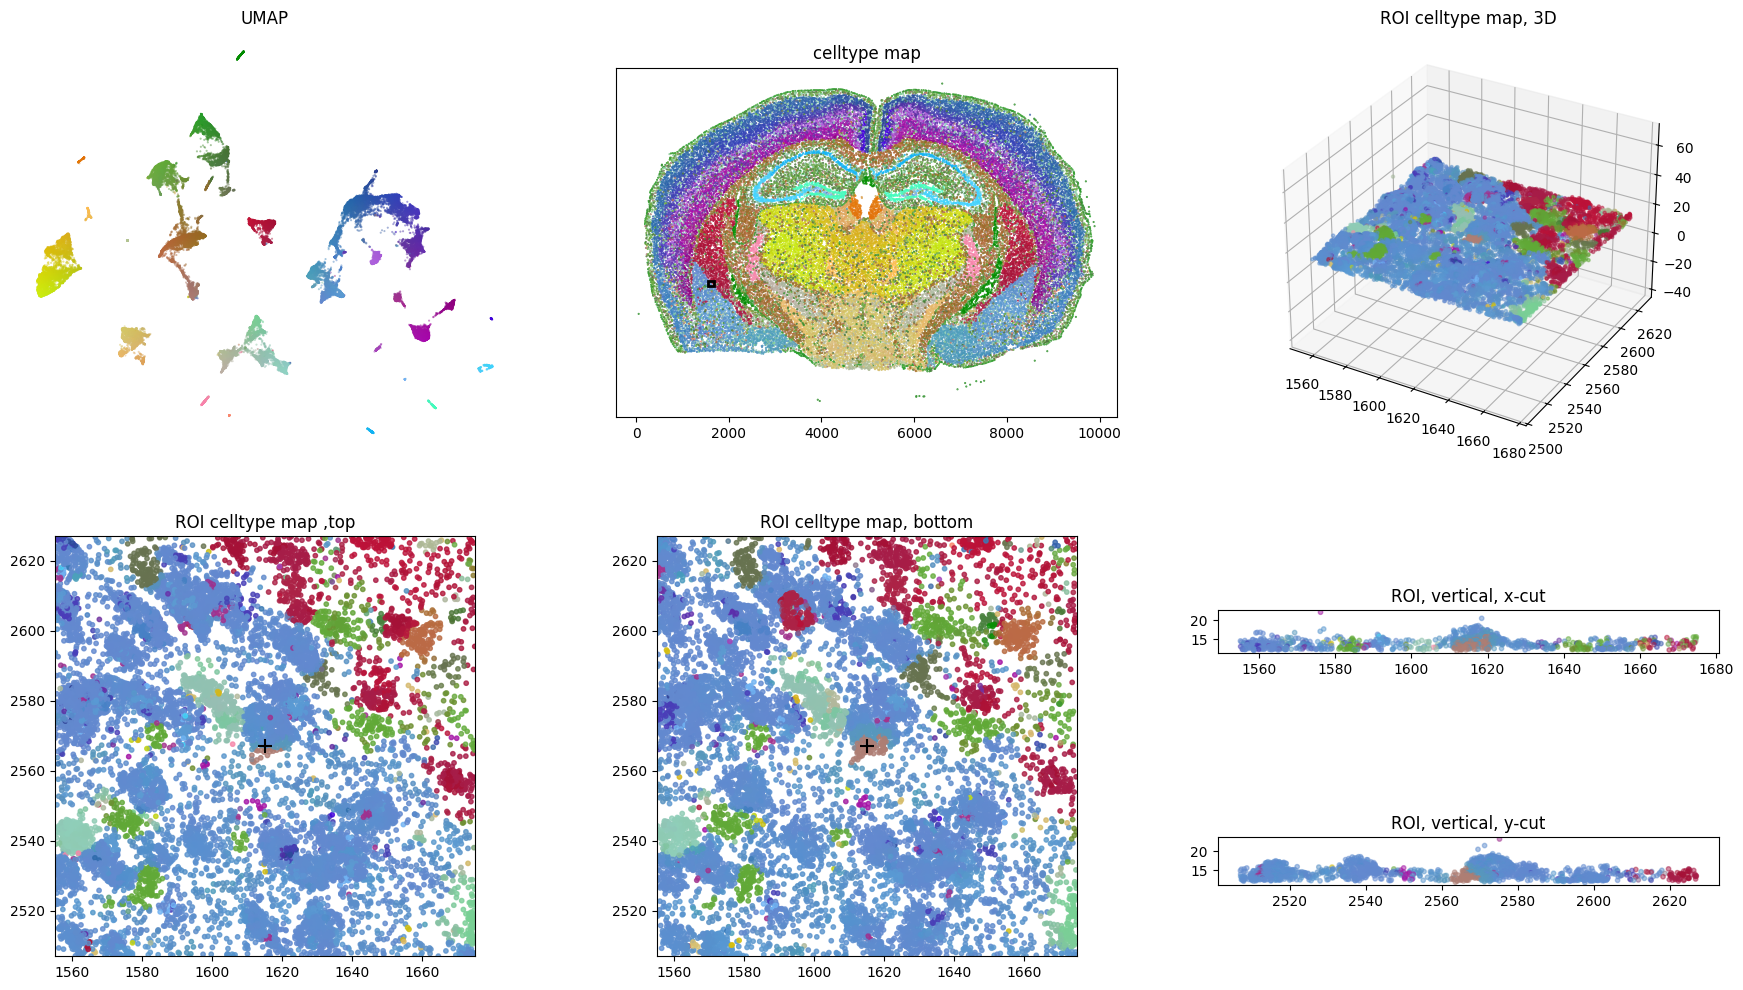

In [36]:
window_size=60
doublet_case = 7000

x,y = doublet_df.loc[doublet_case,['x','y']]

subsample = visualizer.subsample_df(x,y,coordinate_df,window_size=window_size)
subsample_embedding, subsample_embedding_color = visualizer.transform(subsample)

visualizer.plot_instance(subsample,subsample[['x','y']].values,subsample_embedding_color,x,y,window_size=window_size,rasterized=True)

